In [1]:
import os
from classification_models.tfkeras import Classifiers

# Import the ResNet34 model
ResNet34, preprocess_input = Classifiers.get('resnet34')

In [2]:
# Run only for training!
import glob
import math
import datetime
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
# Normalice the angular momentum
from sklearn.preprocessing import normalize

tfd = tfp.distributions
tfpl = tfp.layers
tfk = tf.keras
tfkl = tf.keras.layers

# Change parameters here...
log_dir = "logs/"
os.makedirs(log_dir, exist_ok=True)
data_dir = 'data/' # Change
sizex = 500
sizey = 500
sizez = 3
rand_seed = 123
num_datasets = -1
batch_size = 128
buf_size = 895
nb_epochs = 200
validation_ratio = 0.1

In [3]:
# Collect all the .npz files
numpy_datasets = glob.glob(data_dir+'dataset*')

In [4]:
# load the data into a dictionary from npz files
data_dict = {}
for dataset in numpy_datasets[:num_datasets]:
    with np.load(dataset) as data:
        if 'x_dust' in data_dict.keys():
            data_dict['x_dust']   = np.append( data_dict['x_dust'], data['x_dust'],axis=0)
            data_dict['x_nodust'] = np.append( data_dict['x_nodust'], data['x_nodust'],axis=0)
            data_dict['y']        = np.append( data_dict['y'], data['y'],axis=0)
            data_dict['ids']      = np.append( data_dict['ids'], data['id'],axis=0)
        else:
            data_dict['x_dust']   = data['x_dust']
            data_dict['x_nodust'] = data['x_nodust']
            data_dict['y']        = data['y']
            data_dict['ids']      = data['id']

In [5]:
# check the shape of the dictionary (100 images of 500x500x3 = 4 files of 25 images)
data_dict['x_dust'].shape

(895, 500, 500, 3)

In [6]:
# Compute the angles from the x,y,z labels
# theta = np.arctan(np.sqrt(x**2 + y**2)/z)
# phi = np.arctan(y/x)
def cart_to_esf(xyz):
    angles = np.empty( (len(xyz),2) )
    angles[:,0] = np.arctan2(np.sqrt(xyz[:,0]**2 + xyz[:,1]**2),xyz[:,2]) *180/np.pi #theta angle in degrees
    angles[:,1] = np.arctan2(xyz[:,1],xyz[:,0]) * 180/np.pi #phi angle in degrees
    return angles

# Define the function to go back to cartisian cordinates
def esf_to_cart(angles):
    xyz = np.empty( (len(angles),3) )
    ang_rad = angles*np.pi/180
    xyz[:,0] = np.sin(ang_rad[:,0])*np.cos(ang_rad[:,1])
    xyz[:,1] = np.sin(ang_rad[:,0])*np.sin(ang_rad[:,1])
    xyz[:,2] = np.cos(ang_rad[:,0])
    return xyz

#break the degeneracy of the solutions restricting the solution to 1 sector
def break_degeneracy(angles):
    ang_norm = angles
    for i in range(len(angles)):
        if ang_norm[:,1][i] < 0:
            ang_norm[:,1][i] = (ang_norm[:,1][i] + 180)
    return ang_norm

#map the solution to be between [0,1]
def map_to_1(angles, max = 180 ):
    ang_norm = angles/max
    return ang_norm

def map_to_180(ang_norm):
  angle = ang_norm*180
  return angle

# computing the normaliced angle and the come back to cartesian to check the conversion
data_dict['y_norm'] = normalize(data_dict['y'], axis=1)
data_dict['y_angle'] = cart_to_esf(normalize(data_dict['y'], axis=1))
data_dict['y_angle_norm'] = map_to_1(break_degeneracy(data_dict['y_angle']))
data_dict['y_reverse']= esf_to_cart(map_to_180(data_dict['y_angle_norm']))

In [7]:
# check the shape of our dictionary in te labels entry
print(data_dict['y_angle'].shape)

(895, 2)


In [8]:
# separate in batches and shuffle the data with a fixed seed
#dataset = dataset.batch(batch_size)
#dataset = dataset.shuffle(10, seed=123)
AUTO = tf.data.experimental.AUTOTUNE

In [9]:
# functions to visualice the data 
def viz(img, label, pred=[0,0,0], id=None):
    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(img, cmap='gray', vmin=0, vmax=255,origin='lower')
    ax.arrow(250,250,100*label[0],100*label[1], head_width=7, head_length=10, fc='g', ec='g')
    if sum(abs(pred)) > 0: ax.arrow(250,250,100*pred[0],100*pred[1], head_width=7, head_length=10, fc='r', ec='r')
        
    display(Markdown("#### **cartesian label:** {}".format(label)))
    if sum(abs(pred)) > 0: display(Markdown("#### **inverse from angle:** {}".format(pred)))
    if id: display(Markdown("#### **ID:** {}".format(id)))
    plt.show()
        
# create the dataset from the dictionary and see the size and type
dataset = tf.data.Dataset.from_tensor_slices(data_dict)
print(dataset)

<TensorSliceDataset shapes: {x_dust: (500, 500, 3), x_nodust: (500, 500, 3), y: (3,), ids: (), y_norm: (3,), y_angle: (2,), y_angle_norm: (2,), y_reverse: (3,)}, types: {x_dust: tf.float64, x_nodust: tf.float64, y: tf.float64, ids: tf.string, y_norm: tf.float64, y_angle: tf.float64, y_angle_norm: tf.float64, y_reverse: tf.float64}>


<TakeDataset shapes: {x_dust: (500, 500, 3), x_nodust: (500, 500, 3), y: (3,), ids: (), y_norm: (3,), y_angle: (2,), y_angle_norm: (2,), y_reverse: (3,)}, types: {x_dust: tf.float64, x_nodust: tf.float64, y: tf.float64, ids: tf.string, y_norm: tf.float64, y_angle: tf.float64, y_angle_norm: tf.float64, y_reverse: tf.float64}>


#### **cartesian label:** [0.73639    0.0919113  0.67028507]

#### **inverse from angle:** [0.73639    0.0919113  0.67028507]

#### **ID:** b'g5.38e11_x73_y33_z282'

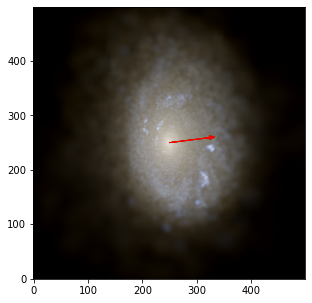

#### **cartesian label:** [0.91321264 0.07612517 0.40030942]

#### **inverse from angle:** [0.91321264 0.07612517 0.40030942]

#### **ID:** b'g3.54e09_x174_y289_z10'

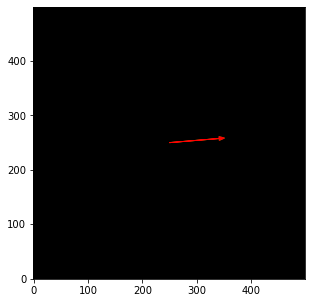

#### **cartesian label:** [-0.86259336  0.32798186  0.38517605]

#### **inverse from angle:** [-0.86259336  0.32798186  0.38517605]

#### **ID:** b'g3.59e11_x327_y67_z51'

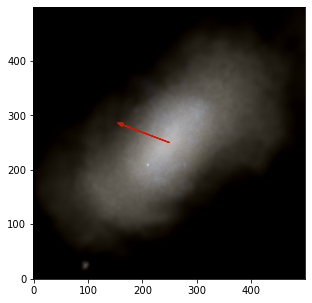

#### **cartesian label:** [ 0.86984429 -0.45869166  0.18158434]

#### **inverse from angle:** [-0.86984429  0.45869166  0.18158434]

#### **ID:** b'g1.23e10_x250_y166_z131'

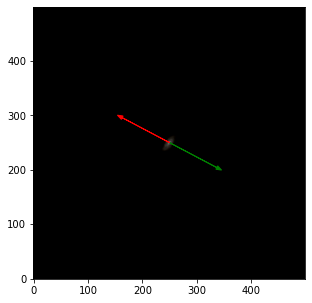

#### **cartesian label:** [-0.49327222  0.23212117 -0.83833303]

#### **inverse from angle:** [-0.49327222  0.23212117 -0.83833303]

#### **ID:** b'g5.38e11_x207_y331_z254'

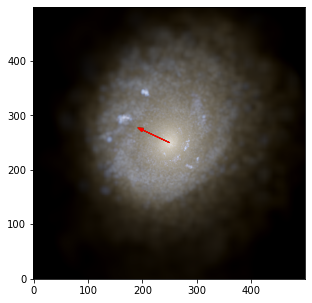

#### **cartesian label:** [-0.61369093  0.6727376  -0.41328872]

#### **inverse from angle:** [-0.61369093  0.6727376  -0.41328872]

#### **ID:** b'g3.55e11_x221_y111_z121'

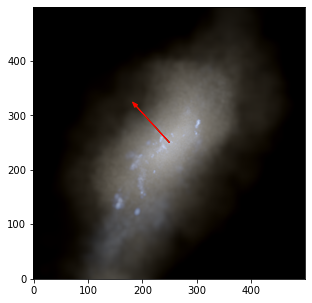

#### **cartesian label:** [-0.19316571  0.37082021  0.90839385]

#### **inverse from angle:** [-0.19316571  0.37082021  0.90839385]

#### **ID:** b'g5.36e11_x334_y80_z22'

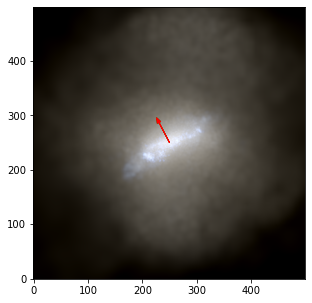

#### **cartesian label:** [-0.32922093  0.7162336   0.6153235 ]

#### **inverse from angle:** [-0.32922093  0.7162336   0.6153235 ]

#### **ID:** b'g1.23e10_x43_y149_z285'

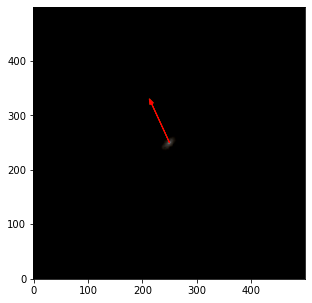

#### **cartesian label:** [-0.34257352 -0.90712284  0.2444822 ]

#### **inverse from angle:** [0.34257352 0.90712284 0.2444822 ]

#### **ID:** b'g5.36e11_x322_y6_z166'

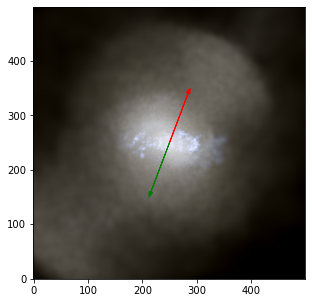

#### **cartesian label:** [-0.72355164  0.60583655 -0.33080975]

#### **inverse from angle:** [-0.72355164  0.60583655 -0.33080975]

#### **ID:** b'g4.94e10_x123_y288_z247'

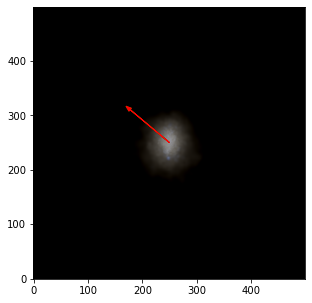

#### **cartesian label:** [0.66018449 0.69187025 0.29235593]

#### **inverse from angle:** [0.66018449 0.69187025 0.29235593]

#### **ID:** b'g1.95e10_x123_y47_z338'

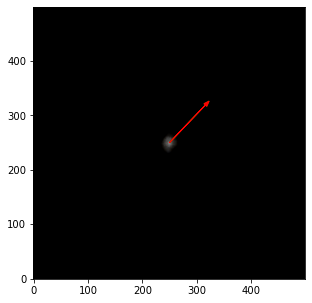

#### **cartesian label:** [-0.66599025  0.00265928  0.74595571]

#### **inverse from angle:** [-0.66599025  0.00265928  0.74595571]

#### **ID:** b'g5.41e09_x295_y89_z219'

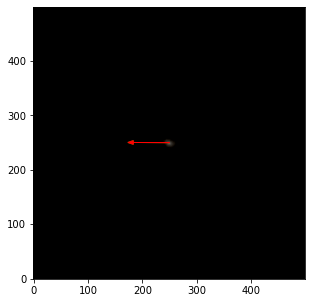

#### **cartesian label:** [ 0.69324104 -0.71946832  0.04221598]

#### **inverse from angle:** [-0.69324104  0.71946832  0.04221598]

#### **ID:** b'g1.95e10_x288_y322_z353'

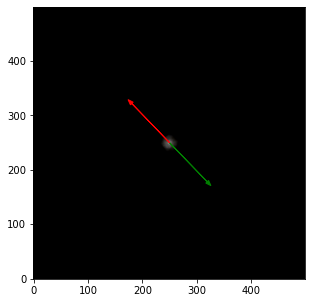

#### **cartesian label:** [-0.69115555 -0.71009083 -0.13444338]

#### **inverse from angle:** [ 0.69115555  0.71009083 -0.13444338]

#### **ID:** b'g1.37e11_x44_y252_z180'

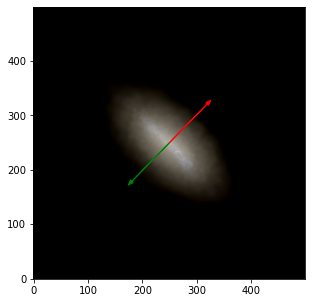

#### **cartesian label:** [ 0.29494192 -0.43530923  0.85059693]

#### **inverse from angle:** [-0.29494192  0.43530923  0.85059693]

#### **ID:** b'g3.55e11_x66_y351_z191'

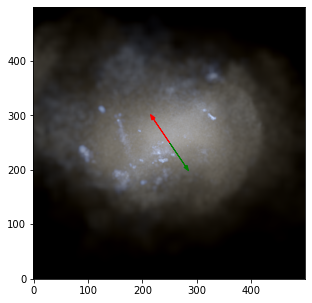

#### **cartesian label:** [-0.91786091  0.17010873 -0.35860058]

#### **inverse from angle:** [-0.91786091  0.17010873 -0.35860058]

#### **ID:** b'g5.36e11_x47_y156_z269'

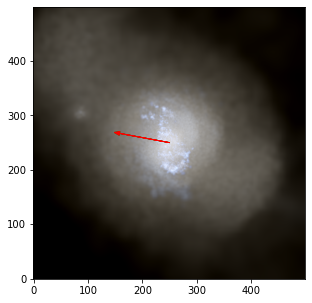

#### **cartesian label:** [-0.21718294  0.75027703  0.6244325 ]

#### **inverse from angle:** [-0.21718294  0.75027703  0.6244325 ]

#### **ID:** b'g1.95e10_x179_y330_z93'

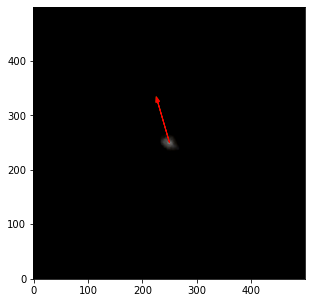

#### **cartesian label:** [-0.17987047 -0.89527474  0.40759019]

#### **inverse from angle:** [0.17987047 0.89527474 0.40759019]

#### **ID:** b'g3.61e11_x27_y342_z178'

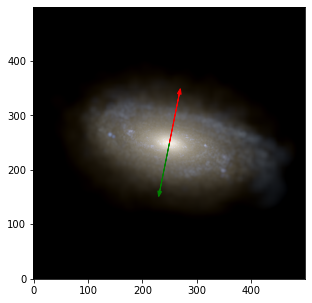

#### **cartesian label:** [-0.88918856 -0.32171447  0.32533598]

#### **inverse from angle:** [0.88918856 0.32171447 0.32533598]

#### **ID:** b'g4.94e10_x166_y340_z309'

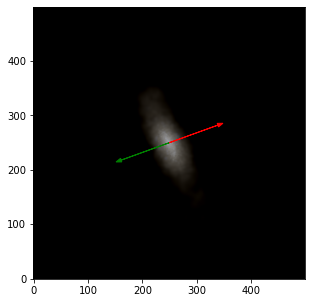

#### **cartesian label:** [-0.29573792  0.63130214 -0.71693562]

#### **inverse from angle:** [-0.29573792  0.63130214 -0.71693562]

#### **ID:** b'g1.37e11_x135_y190_z169'

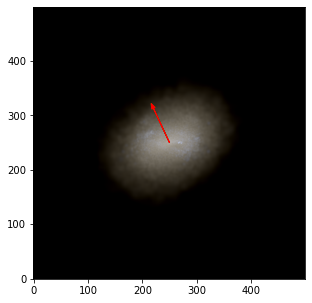

#### **cartesian label:** [-0.81971956  0.48278548  0.30818506]

#### **inverse from angle:** [-0.81971956  0.48278548  0.30818506]

#### **ID:** b'g3.55e11_x329_y50_z81'

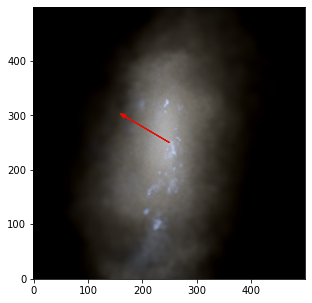

#### **cartesian label:** [ 0.6172725  -0.63130883  0.46949316]

#### **inverse from angle:** [-0.6172725   0.63130883  0.46949316]

#### **ID:** b'g2.63e10_x257_y343_z42'

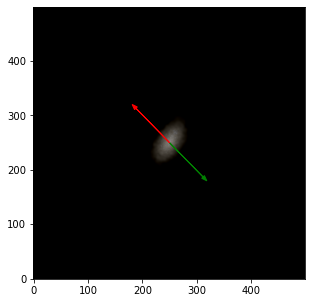

#### **cartesian label:** [-0.43697101  0.69748614 -0.56795196]

#### **inverse from angle:** [-0.43697101  0.69748614 -0.56795196]

#### **ID:** b'g5.41e09_x102_y283_z162'

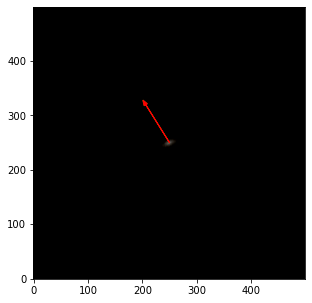

#### **cartesian label:** [-0.99880214  0.0388277  -0.02977732]

#### **inverse from angle:** [-0.99880214  0.0388277  -0.02977732]

#### **ID:** b'g2.63e10_x280_y174_z47'

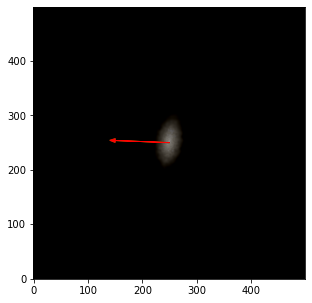

#### **cartesian label:** [-0.38426673  0.540603    0.74838992]

#### **inverse from angle:** [-0.38426673  0.540603    0.74838992]

#### **ID:** b'g4.99e09_x212_y252_z226'

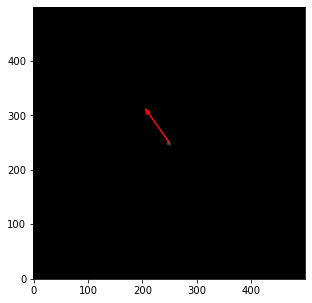

#### **cartesian label:** [-0.12765322 -0.17346013 -0.97653276]

#### **inverse from angle:** [ 0.12765322  0.17346013 -0.97653276]

#### **ID:** b'g5.38e11_x306_y331_z103'

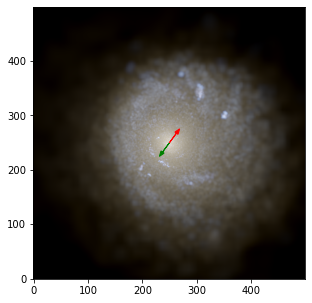

#### **cartesian label:** [0.88725895 0.42045919 0.18969879]

#### **inverse from angle:** [0.88725895 0.42045919 0.18969879]

#### **ID:** b'g1.95e10_x315_y306_z185'

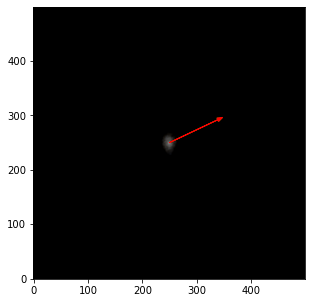

#### **cartesian label:** [0.91259124 0.15694979 0.37754999]

#### **inverse from angle:** [0.91259124 0.15694979 0.37754999]

#### **ID:** b'g3.61e11_x245_y270_z114'

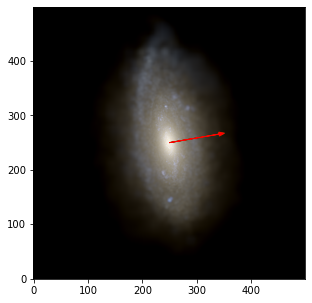

#### **cartesian label:** [-0.1008616  -0.81460832  0.57117442]

#### **inverse from angle:** [0.1008616  0.81460832 0.57117442]

#### **ID:** b'g1.37e11_x209_y214_z29'

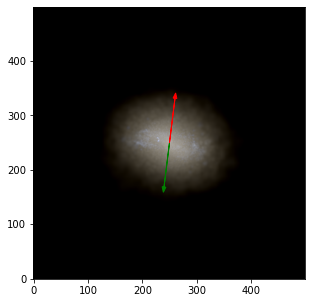

#### **cartesian label:** [ 0.8499309   0.45364209 -0.26800434]

#### **inverse from angle:** [ 0.8499309   0.45364209 -0.26800434]

#### **ID:** b'g5.41e09_x127_y125_z7'

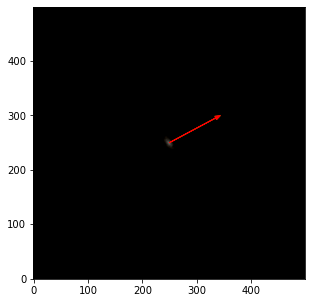

#### **cartesian label:** [0.02948026 0.34284227 0.93893029]

#### **inverse from angle:** [0.02948026 0.34284227 0.93893029]

#### **ID:** b'g1.95e10_x162_y90_z170'

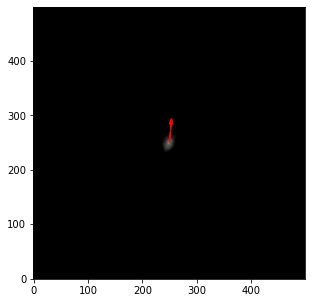

#### **cartesian label:** [ 0.90097311 -0.172498   -0.39811041]

#### **inverse from angle:** [-0.90097311  0.172498   -0.39811041]

#### **ID:** b'g1.37e11_x197_y226_z282'

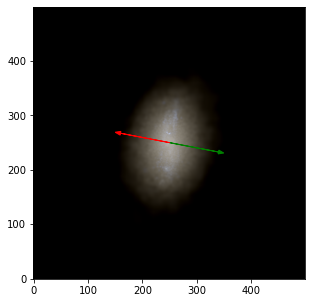

#### **cartesian label:** [0.62823455 0.43874003 0.64251734]

#### **inverse from angle:** [0.62823455 0.43874003 0.64251734]

#### **ID:** b'g5.38e11_x38_y94_z56'

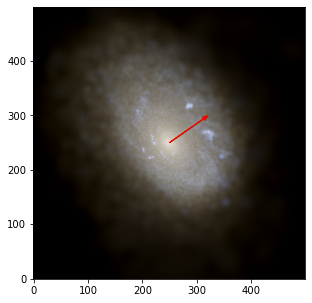

#### **cartesian label:** [-0.77315658 -0.56731877 -0.28351069]

#### **inverse from angle:** [ 0.77315658  0.56731877 -0.28351069]

#### **ID:** b'g3.67e09_x150_y22_z295'

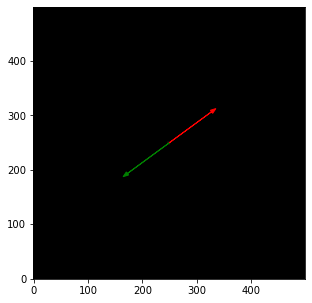

#### **cartesian label:** [-0.53151707  0.35771106 -0.76781013]

#### **inverse from angle:** [-0.53151707  0.35771106 -0.76781013]

#### **ID:** b'g2.63e10_x103_y307_z342'

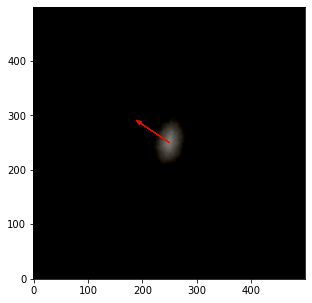

#### **cartesian label:** [ 0.93272602 -0.02630288  0.35962526]

#### **inverse from angle:** [-0.93272602  0.02630288  0.35962526]

#### **ID:** b'g4.99e09_x335_y50_z204'

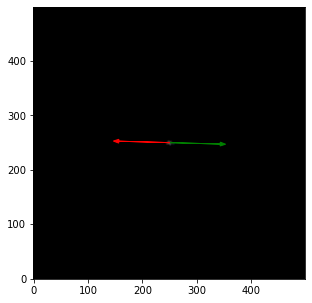

#### **cartesian label:** [ 0.47545202 -0.7479115   0.46322108]

#### **inverse from angle:** [-0.47545202  0.7479115   0.46322108]

#### **ID:** b'g4.99e09_x228_y353_z309'

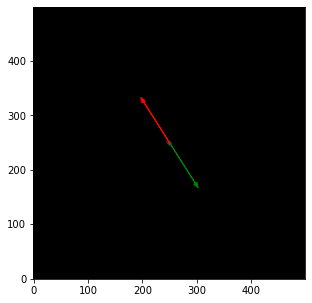

#### **cartesian label:** [-0.50798035 -0.84076589 -0.18726633]

#### **inverse from angle:** [ 0.50798035  0.84076589 -0.18726633]

#### **ID:** b'g3.67e09_x258_y60_z123'

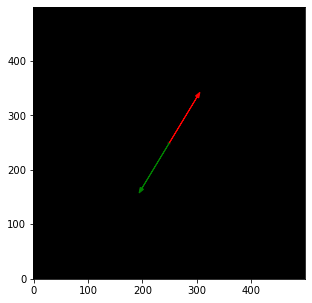

#### **cartesian label:** [-0.03163472  0.32906174  0.94377837]

#### **inverse from angle:** [-0.03163472  0.32906174  0.94377837]

#### **ID:** b'g5.41e09_x55_y308_z38'

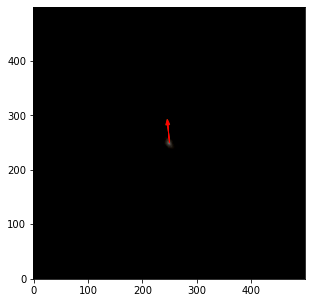

#### **cartesian label:** [ 0.1628246  -0.18432114  0.96928524]

#### **inverse from angle:** [-0.1628246   0.18432114  0.96928524]

#### **ID:** b'g1.37e11_x100_y12_z320'

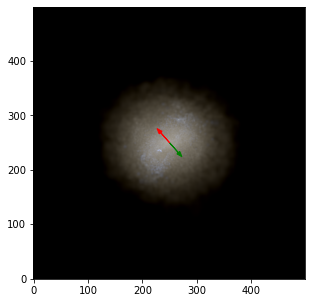

#### **cartesian label:** [-0.03772952 -0.99885834  0.02930026]

#### **inverse from angle:** [0.03772952 0.99885834 0.02930026]

#### **ID:** b'g2.63e10_x314_y27_z84'

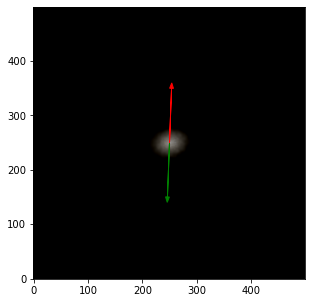

#### **cartesian label:** [0.25409979 0.44085076 0.8608623 ]

#### **inverse from angle:** [0.25409979 0.44085076 0.8608623 ]

#### **ID:** b'g2.04e11_x32_y348_z247'

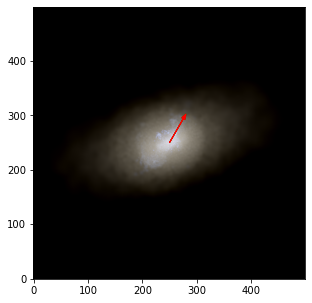

#### **cartesian label:** [ 0.15534309  0.30708814 -0.93891714]

#### **inverse from angle:** [ 0.15534309  0.30708814 -0.93891714]

#### **ID:** b'g5.38e11_x62_y191_z42'

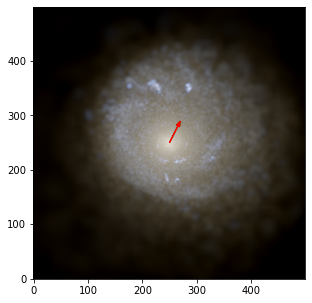

#### **cartesian label:** [ 0.80941295 -0.4433154  -0.38512613]

#### **inverse from angle:** [-0.80941295  0.4433154  -0.38512613]

#### **ID:** b'g2.04e11_x75_y180_z107'

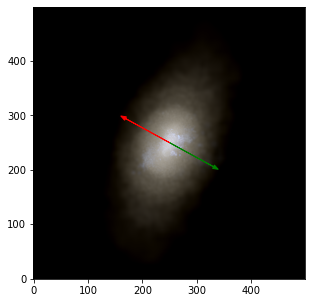

#### **cartesian label:** [ 0.5943001   0.26434593 -0.75955818]

#### **inverse from angle:** [ 0.5943001   0.26434593 -0.75955818]

#### **ID:** b'g5.46e11_x134_y99_z113'

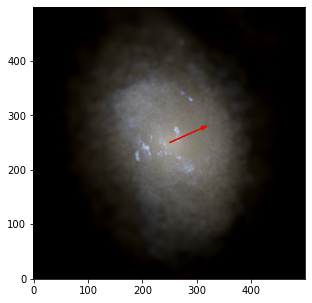

#### **cartesian label:** [ 0.66822637 -0.63599717 -0.38598074]

#### **inverse from angle:** [-0.66822637  0.63599717 -0.38598074]

#### **ID:** b'g1.44e10_x134_y105_z17'

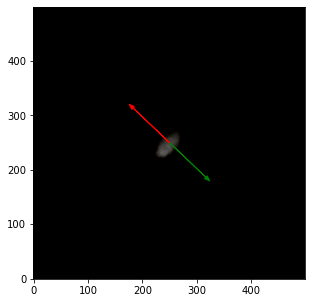

#### **cartesian label:** [ 0.66067721 -0.66746242 -0.34351062]

#### **inverse from angle:** [-0.66067721  0.66746242 -0.34351062]

#### **ID:** b'g4.99e09_x232_y120_z320'

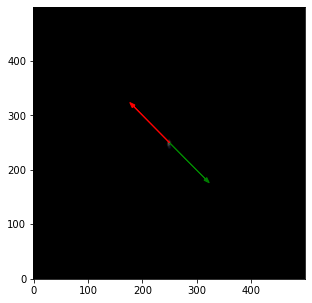

#### **cartesian label:** [-0.77722111  0.61038491 -0.15283197]

#### **inverse from angle:** [-0.77722111  0.61038491 -0.15283197]

#### **ID:** b'g5.38e11_x132_y272_z195'

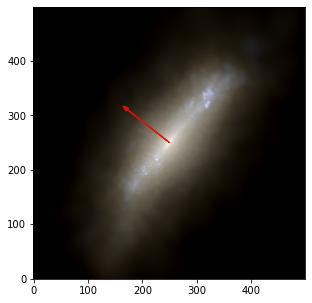

#### **cartesian label:** [ 0.26683057  0.94434909 -0.19237007]

#### **inverse from angle:** [ 0.26683057  0.94434909 -0.19237007]

#### **ID:** b'g2.63e10_x292_y291_z200'

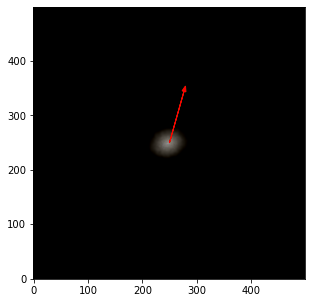

#### **cartesian label:** [ 0.15638695 -0.4435516  -0.88249935]

#### **inverse from angle:** [-0.15638695  0.4435516  -0.88249935]

#### **ID:** b'g3.67e09_x15_y26_z204'

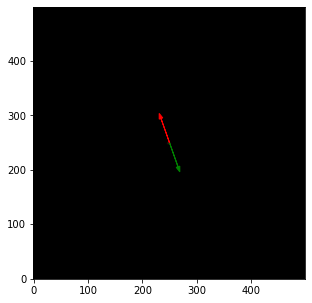

#### **cartesian label:** [-0.00401964  0.85731479 -0.51477683]

#### **inverse from angle:** [-0.00401964  0.85731479 -0.51477683]

#### **ID:** b'g2.64e10_x206_y343_z189'

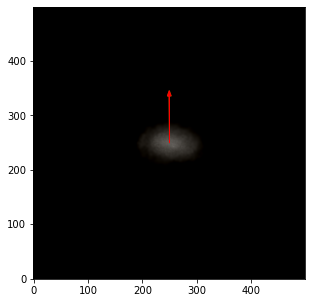

#### **cartesian label:** [0.60372397 0.50250106 0.61887806]

#### **inverse from angle:** [0.60372397 0.50250106 0.61887806]

#### **ID:** b'g2.04e11_x329_y264_z18'

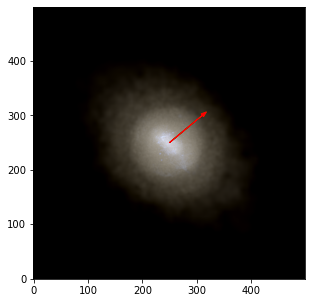

#### **cartesian label:** [-0.09313731 -0.2879077  -0.95311835]

#### **inverse from angle:** [ 0.09313731  0.2879077  -0.95311835]

#### **ID:** b'g1.44e10_x106_y182_z5'

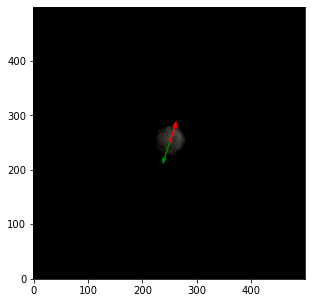

#### **cartesian label:** [-0.49780175 -0.32716872  0.80321482]

#### **inverse from angle:** [0.49780175 0.32716872 0.80321482]

#### **ID:** b'g4.99e09_x118_y96_z245'

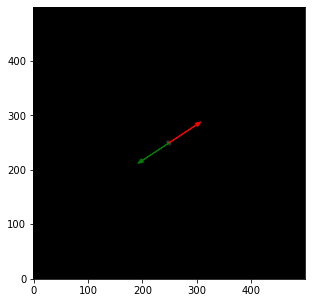

#### **cartesian label:** [-0.83334826  0.40990538  0.37082107]

#### **inverse from angle:** [-0.83334826  0.40990538  0.37082107]

#### **ID:** b'g3.67e09_x337_y336_z53'

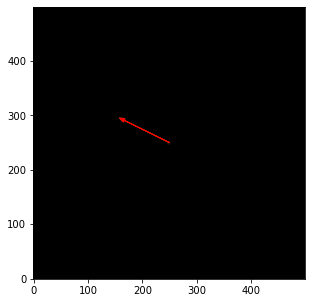

#### **cartesian label:** [ 0.76633119 -0.43389524 -0.47378416]

#### **inverse from angle:** [-0.76633119  0.43389524 -0.47378416]

#### **ID:** b'g5.38e11_x303_y322_z211'

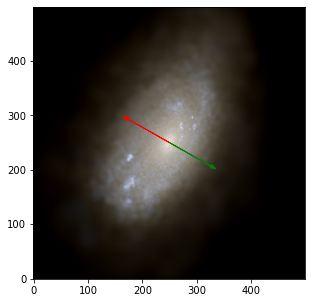

#### **cartesian label:** [ 0.07250654 -0.27648412  0.95827936]

#### **inverse from angle:** [-0.07250654  0.27648412  0.95827936]

#### **ID:** b'g5.46e11_x111_y17_z326'

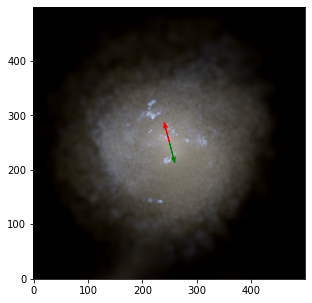

#### **cartesian label:** [ 0.0164017   0.97917645 -0.20234738]

#### **inverse from angle:** [ 0.0164017   0.97917645 -0.20234738]

#### **ID:** b'g5.41e09_x74_y147_z31'

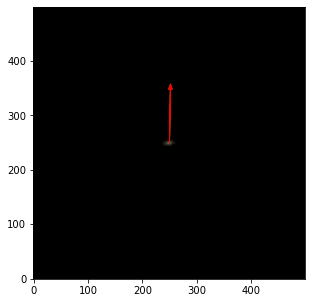

#### **cartesian label:** [-0.83623181 -0.1611941   0.52414962]

#### **inverse from angle:** [0.83623181 0.1611941  0.52414962]

#### **ID:** b'g2.64e10_x150_y358_z281'

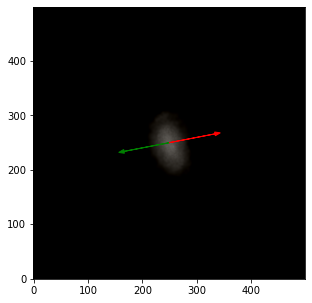

#### **cartesian label:** [-0.09102648  0.98651418  0.13602925]

#### **inverse from angle:** [-0.09102648  0.98651418  0.13602925]

#### **ID:** b'g3.67e09_x140_y160_z225'

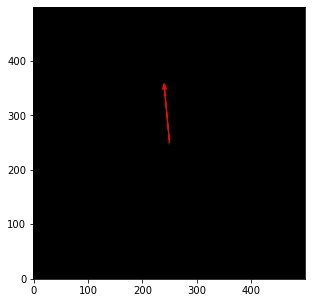

#### **cartesian label:** [ 0.67068764 -0.74169834 -0.00785318]

#### **inverse from angle:** [-0.67068764  0.74169834 -0.00785318]

#### **ID:** b'g2.04e11_x297_y199_z159'

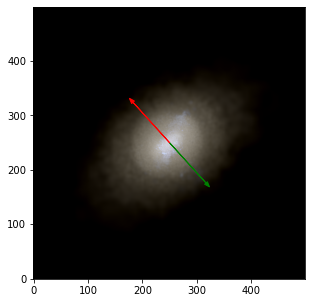

#### **cartesian label:** [ 0.25258166 -0.28218473 -0.92551298]

#### **inverse from angle:** [-0.25258166  0.28218473 -0.92551298]

#### **ID:** b'g1.44e10_x110_y175_z335'

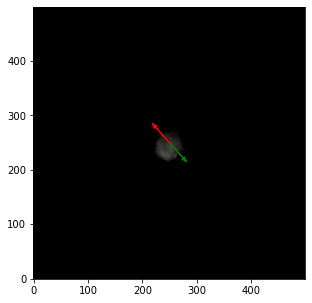

#### **cartesian label:** [-0.42945952  0.8791846  -0.20639515]

#### **inverse from angle:** [-0.42945952  0.8791846  -0.20639515]

#### **ID:** b'g4.99e10_x337_y77_z0'

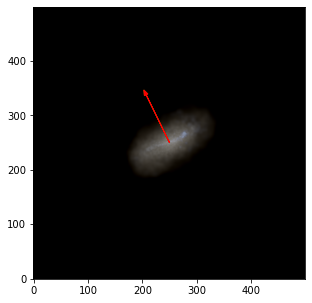

#### **cartesian label:** [-0.3049081   0.34634282  0.887174  ]

#### **inverse from angle:** [-0.3049081   0.34634282  0.887174  ]

#### **ID:** b'g5.46e11_x311_y196_z302'

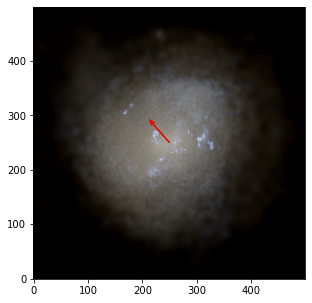

#### **cartesian label:** [ 0.90245685  0.24780679 -0.35236831]

#### **inverse from angle:** [ 0.90245685  0.24780679 -0.35236831]

#### **ID:** b'g5.46e11_x306_y325_z297'

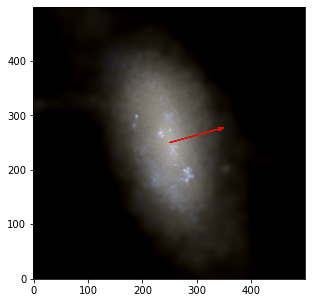

#### **cartesian label:** [-0.20195752  0.66771005  0.71650293]

#### **inverse from angle:** [-0.20195752  0.66771005  0.71650293]

#### **ID:** b'g1.44e10_x349_y87_z49'

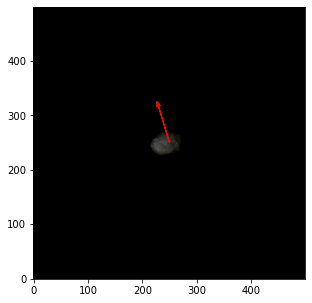

#### **cartesian label:** [-0.37620139 -0.56390583  0.7351753 ]

#### **inverse from angle:** [0.37620139 0.56390583 0.7351753 ]

#### **ID:** b'g4.99e10_x51_y300_z214'

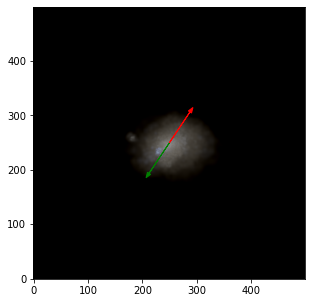

#### **cartesian label:** [ 0.63947286 -0.45376403  0.6206228 ]

#### **inverse from angle:** [-0.63947286  0.45376403  0.6206228 ]

#### **ID:** b'g2.04e11_x24_y64_z206'

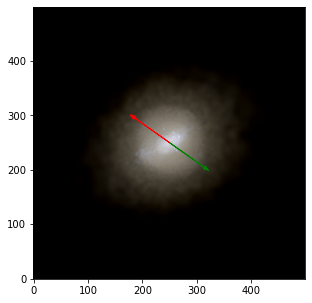

#### **cartesian label:** [-0.93940711 -0.33271507 -0.0825528 ]

#### **inverse from angle:** [ 0.93940711  0.33271507 -0.0825528 ]

#### **ID:** b'g2.64e10_x116_y249_z30'

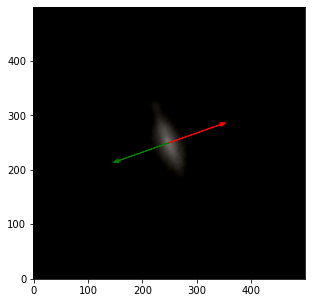

#### **cartesian label:** [ 0.47039257  0.80015532 -0.37213208]

#### **inverse from angle:** [ 0.47039257  0.80015532 -0.37213208]

#### **ID:** b'g3.67e10_x52_y151_z90'

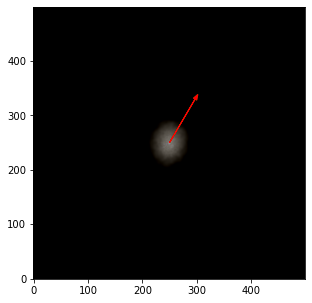

#### **cartesian label:** [ 0.92382082  0.01065692 -0.38267679]

#### **inverse from angle:** [ 0.92382082  0.01065692 -0.38267679]

#### **ID:** b'g5.41e09_x264_y231_z69'

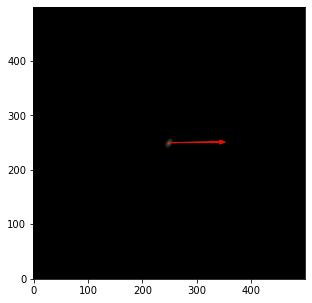

#### **cartesian label:** [-0.91775208 -0.06713284 -0.39143876]

#### **inverse from angle:** [ 0.91775208  0.06713284 -0.39143876]

#### **ID:** b'g2.64e10_x89_y248_z106'

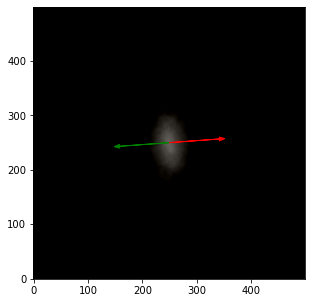

#### **cartesian label:** [-0.18443724 -0.55071357  0.81406232]

#### **inverse from angle:** [0.18443724 0.55071357 0.81406232]

#### **ID:** b'g1.44e10_x234_y149_z332'

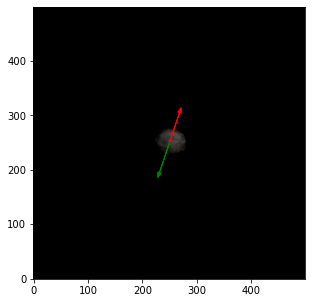

#### **cartesian label:** [-0.12062234  0.08992718  0.98861689]

#### **inverse from angle:** [-0.12062234  0.08992718  0.98861689]

#### **ID:** b'g5.84e09_x149_y303_z91'

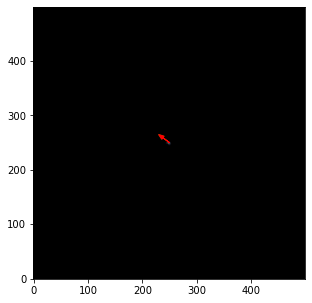

#### **cartesian label:** [-0.65453893  0.73527253 -0.17593489]

#### **inverse from angle:** [-0.65453893  0.73527253 -0.17593489]

#### **ID:** b'g5.41e09_x168_y171_z70'

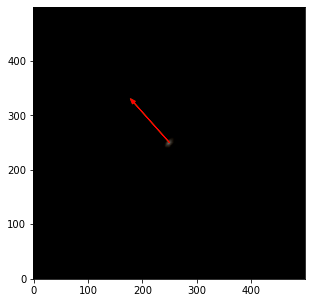

#### **cartesian label:** [0.40737195 0.27925497 0.86951984]

#### **inverse from angle:** [0.40737195 0.27925497 0.86951984]

#### **ID:** b'g3.67e10_x11_y4_z288'

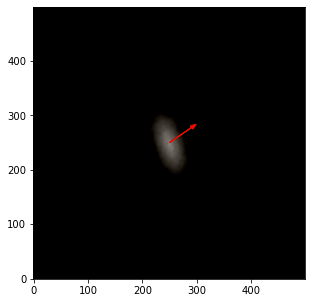

#### **cartesian label:** [-0.35816362 -0.64519647  0.6748632 ]

#### **inverse from angle:** [0.35816362 0.64519647 0.6748632 ]

#### **ID:** b'g5.46e11_x50_y326_z189'

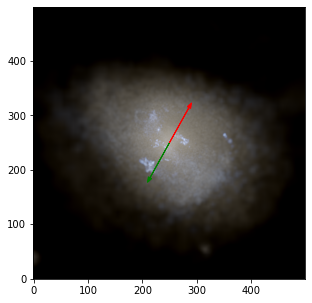

#### **cartesian label:** [ 0.34065927 -0.85354643 -0.39422043]

#### **inverse from angle:** [-0.34065927  0.85354643 -0.39422043]

#### **ID:** b'g4.99e10_x210_y304_z342'

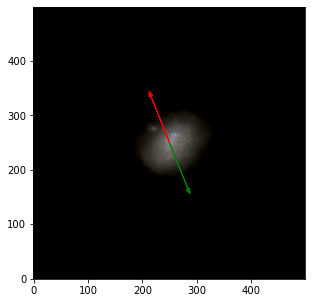

In [10]:
# visualice the data
elem = dataset.take(1)
print(elem)
for e in elem:
    viz(e['x_nodust'], e['y_norm'],e['y_reverse'], e['ids'])

real_dataset = dataset.batch(batch_size).shuffle(10, seed=rand_seed)
for idx in range(1,15):
    elements = real_dataset.take(idx)
    for elem in elements:
        viz(elem['x_nodust'][idx], elem['y_norm'][idx],elem['y_reverse'][idx], elem['ids'][idx]) # select any index within the batch, e.g. 2

In [11]:
# defining the train and validation dataset from the existing dictionary, shufling and batching
ds_size = len(data_dict['y_angle_norm'])

input_ds = (
    tf.data.Dataset.from_tensor_slices((data_dict['x_nodust'].astype(np.float32), data_dict['y_angle_norm'].astype(np.float32)))
                    # Use seed to ensure we always have the same validation data set!
                   .shuffle(ds_size, seed = rand_seed, reshuffle_each_iteration = False)
)

val_size = math.floor(ds_size * validation_ratio)
validation_ds = ( input_ds.take(val_size).batch(batch_size) )
train_ds = ( input_ds.skip(val_size).shuffle(buffer_size=buf_size, reshuffle_each_iteration=True).batch(batch_size) )

print(train_ds)
print(validation_ds)

<BatchDataset shapes: ((None, 500, 500, 3), (None, 2)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 500, 500, 3), (None, 2)), types: (tf.float32, tf.float32)>


In [12]:
%reload_ext tensorboard
%tensorboard --logdir {log_dir} --reload_multifile True --host 0.0.0.0 --port 6006

In [13]:
# Build model
base_model = ResNet34(input_shape=(sizey,sizex,3), weights='imagenet', include_top=False)

# redefine the output to be from tensorflow probability a PDF
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x_2 = tf.keras.layers.Dense(tfpl.IndependentNormal.params_size(2), activation=None)(x)
#tfpl.IndependentNormal(input_shape, tfd.Normal.mean),
output = tfpl.IndependentNormal(2, tfd.Normal.sample)(x_2)
model = tf.keras.models.Model(inputs=[base_model.input], outputs=[output])

# Use existing best weights if available...
snapshot_weights = 'best_weights_angles_adam.hdf5'
#if os.path.isfile(snapshot_weights):
#    model.load_weights(snapshot_weights)

negloglik = lambda y, p_y: -p_y.log_prob(y)
    
#model.compile(optimizer='SGD', loss=negloglik, metrics=['accuracy'])
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik, metrics=['accuracy'])
# model.summary()

In [14]:
# For tensorboard
log_dir_s = log_dir + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
os.makedirs(log_dir_s, exist_ok=True)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir_s, histogram_freq=1, update_freq='batch', profile_batch=0)

# Checkpointing
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath=snapshot_weights,
                               monitor='val_accuracy',
                               verbose=1,
                               save_best_only=True)

callbacks = [
    tensorboard_callback,
    checkpointer
]

model.fit(
    train_ds,
    validation_data = validation_ds,
    epochs = nb_epochs,
    callbacks = callbacks,)
    # class_weight=class_weight)

model.save('models/trained.h5') # Not really needed as we have the weights already

Epoch 1/200
7/7 [==============================] - ETA: 0s - loss: 764.1115 - accuracy: 0.4913 
Epoch 00001: val_accuracy improved from -inf to 0.57303, saving model to best_weights_angles_adam.hdf5
7/7 [==============================] - 182s 26s/step - loss: 764.1115 - accuracy: 0.4913 - val_loss: 90.3006 - val_accuracy: 0.5730
Epoch 2/200
7/7 [==============================] - ETA: 0s - loss: 5.6991 - accuracy: 0.4752 
Epoch 00002: val_accuracy improved from 0.57303 to 0.59551, saving model to best_weights_angles_adam.hdf5
7/7 [==============================] - 184s 26s/step - loss: 5.6991 - accuracy: 0.4752 - val_loss: 81.2594 - val_accuracy: 0.5955
Epoch 3/200
7/7 [==============================] - ETA: 0s - loss: 5.9271 - accuracy: 0.4926 
Epoch 00003: val_accuracy did not improve from 0.59551
7/7 [==============================] - 183s 26s/step - loss: 5.9271 - accuracy: 0.4926 - val_loss: 73.1030 - val_accuracy: 0.5393
Epoch 4/200
7/7 [==============================] - ETA: 0s -

KeyboardInterrupt: 

In [ ]:
domain = np.linspace(0,1,100)
val_ex, = validation_ds.take(1)
images, labels = val_ex[0], val_ex[1]
outputs = np.array([model.predict(val_ex)])

for i in range(len(domain)):
    outputs = np.append(outputs, [model.predict(val_ex)],axis=0)

In [ ]:
for i in range(5):
    plt.hist(np.array(outputs[:,i,0]),alpha=0.3)
    plt.hist(np.array(outputs[:,i,1]),alpha=0.3)
    plt.show()

In [ ]:
means = np.mean(outputs,axis=0)

#print(means)
#print(labels)

In [ ]:
labels = esf_to_cart(map_to_180(labels))
predictions = esf_to_cart(map_to_180(means))

#print(labels)
#print(predictions)

for img,label,pred,i in zip(images,labels,predictions,range(10)):
    viz(img, label, pred)